In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/sebastian/masters/') # add my repo to python path
import os
import torch
import torch.nn.functional as F
import torch_geometric
import kmbio  # fork of biopython PDB with some changes in how the structure, chain, etc. classes are defined.
import numpy as np
import proteinsolver
import modules

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import *
from torch import nn, optim
from pathlib import Path

from modules.dataset import *
from modules.utils import *
from modules.model import *
from modules.lstm_utils import *

np.random.seed(1)

### Paths

In [2]:
root = Path("/home/sebastian/masters/data/")
data_root = root / "neat_data"
metadata_path = data_root / "embedding_dataset.csv"
processed_dir = data_root / "processed" / "embedding_verification"
state_file = root / "state_files" / "e53-s1952148-d93703104.state"
out_dir = root / "state_files" / "embedding_verification"

### Load positive examples and generate different structure configurations

In [3]:
class ChainFilter(kmbio.PDB.Select):
    def __init__(self, subset):
        self.subset = subset

    def accept_chain(self, chain):
        if chain.id in self.subset:
            return 1
        else:
            return 0

overwrite = False

raw_files, targets = get_data(
    model_dir=data_root / "raw" / "tcrpmhc",
    metadata=data_root / "metadata.csv",
)
mask = np.ma.masked_array(raw_files, mask=targets)  # only get positives

pmhc_chain_subset = ["M", "P"]
p_chain_subset = ["P"]
annotated_paths = list()

outdir_1 = data_root / "raw" / "pmhc"
outdir_2 = data_root / "raw" / "p"

outdir_1.mkdir(parents=True, exist_ok=True)
outdir_2.mkdir(parents=True, exist_ok=True)
for raw_file in raw_files[mask.mask]:

    model_id = raw_file.name.split("_")[0]
    pmhc_file_name = outdir_1 / f"{model_id}_pmhc.pdb"
    p_file_name =  outdir_2/ f"{model_id}_p.pdb"
    
    if overwrite or (not pmhc_file_name.is_file() or not p_file_name.is_file()):
        structure  = kmbio.PDB.load(raw_file)
    
        io = kmbio.PDB.io.PDBIO()
        io.set_structure(structure)
        io.save(pmhc_file_name, ChainFilter(subset=pmhc_chain_subset))
    
        io = kmbio.PDB.io.PDBIO()
        io.set_structure(structure)
        io.save(p_file_name, ChainFilter(subset=p_chain_subset))

    annotated_paths.append([raw_file, "0"])  # add indices of peptide
    annotated_paths.append([pmhc_file_name, "1"])  # add indices of peptide
    annotated_paths.append([p_file_name, "2"])  # add indices of peptide

with open(metadata_path, "w") as metadata_outfile:
    for data in annotated_paths:
        print(data[0], data[1], sep=",", file=metadata_outfile)

### GNN embeddings

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# init proteinsolver gnn
num_features = 20
adj_input_size = 2
hidden_size = 128

gnn = Net(
    x_input_size=num_features + 1, 
    adj_input_size=adj_input_size, 
    hidden_size=hidden_size, 
    output_size=num_features
)
gnn.load_state_dict(torch.load(state_file, map_location=device))
gnn.eval()
gnn = gnn.to(device)

# load dataset
raw_files = list()
targets = list()
with open(metadata_path, "r") as infile:
    for line in infile:
        line = line.strip().split(",")
        raw_files.append(line[0])
        targets.append(int(line[1]))

raw_files = np.array(raw_files)
targets = np.array(targets)

dataset = ProteinDataset(processed_dir, raw_files, targets, overwrite=False)
data_loader = iter(torch_geometric.loader.DataLoader(dataset, shuffle=False, batch_size=1))

# create gnn embedding
targets = list()
for i, data in enumerate(data_loader):
    out_path = processed_dir / "gnn_out" / f"data_{i}.pt"
    if not out_path.is_file() or overwrite:
        data = data.to(device)
        with torch.no_grad():
            out = gnn(data.x, data.edge_index, data.edge_attr)
        peptide_emb = out[data.chain_map[0] == "P"]  # idx 0 as we only have 1 batch
        torch.save(peptide_emb, out_path)
    targets.append([data.y])
torch.save(targets, processed_dir / "gnn_out" / f"targets.pt")

### Init LSTM

In [12]:
class MyLSTM(nn.Module):
    def __init__(self, num_features, hidden_size, num_layers, num_classes):
        super(MyLSTM, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.8, 
        )
        #self.linear_0 = nn.Linear(hidden_size, hidden_size)
        #self.dropout = nn.Dropout(p=0.5)
        self.linear_1 = nn.Linear(hidden_size, int(hidden_size/2))
        self.linear_2 = nn.Linear(int(hidden_size/2), num_classes)
        
        #torch.nn.init.xavier_uniform_(self.linear.weight)
    
    def forward(self, x):
        x, (h, c) = self.lstm(x)
        out = self.linear_1(h[-1])
        out = F.relu(out)
        out = self.linear_2(out)
        return out


# init LSTM
batch_size = 32
vocab_size = 20
hidden_size = 64
num_layers = 2
num_classes = 3
epochs = 35
n_splits = 5

dataset = LSTMDataset(
    data_dir=processed_dir / "gnn_out", 
    annotations_path=processed_dir / "gnn_out" / "targets.pt"
)
#dataset = torch.utils.data.Subset(dataset, list(range(0, 1000)))
#data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

### K fold CV training

In [ ]:
# touch files to ensure output
save_dir = get_non_dupe_dir(out_dir)
loss_paths = touch_output_files(save_dir, "loss", n_splits)
state_paths = touch_output_files(save_dir, "state", n_splits)
pred_paths = touch_output_files(save_dir, "pred", n_splits)

CV = KFold(n_splits=n_splits, shuffle=True)
i = 0
for train_idx, valid_idx in CV.split(dataset):
    net = MyLSTM(
        num_features=vocab_size, 
        hidden_size=hidden_size, 
        num_layers=num_layers, 
        num_classes=num_classes
    )
    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001) 
    
    #train_subset = torch.utils.data.Subset(dataset, train_idx)
    #valid_subset = torch.utils.data.Subset(dataset, valid_idx)
    
    net, train_losses, valid_losses = lstm_train(
        net,
        epochs,
        criterion,
        optimizer,
        dataset,
        train_idx, 
        valid_idx,
        batch_size,
        device,
    )
    torch.save({"train": train_losses, "valid": valid_losses}, loss_paths[i])
    torch.save(net.state_dict(), state_paths[i])
    
    pred, true = lstm_predict(
        net,
        dataset,
        valid_idx,
        device,
    )     
    torch.save(
        {
            "y_pred": torch.stack(pred).squeeze(1), 
            "y_true": torch.stack(true).squeeze(1),
        }, 
        pred_paths[i]
    )
    
    i += 1

### Compute performance metrics on predictions

In [54]:
# compute performance
labels = ["TCRpMHC", "pMHC", "p"]
performance_data = dict()
for i in range(n_splits):
    data = torch.load(pred_paths[i])
    i = 4
    y_pred = data["y_pred"]
    y_true = data["y_true"]
    
    # confusion matrix
    y_pred_max = torch.argmax(y_pred, dim=1, keepdim=True)
    cm = confusion_matrix(y_true, y_pred_max)

    # f1
    f1 = f1_score(y_pred_max, y_true, average="weighted")

    # multiclass auc
    auc = roc_auc_score(y_true, y_pred, multi_class="ovr", average="weighted")

    output = {
        "f1": f1,
        "auc": auc,
        "cm": cm,
        "labels": labels
    }
    performance_data[i] = output

performance_file = save_dir / "performance_data.pt"
torch.save(performance_data, performance_file)

Fold 4:
Multiclass AUC=1.0
F1=0.9966669070108395


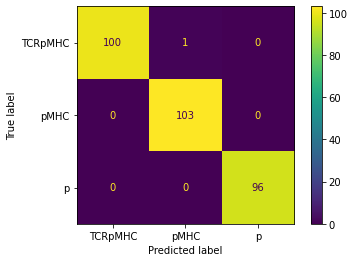

In [59]:
fold_idx = 4
data = torch.load(performance_file)[fold_idx]

cm, f1, auc = data["cm"], data["f1"], data["auc"]
disp = ConfusionMatrixDisplay(cm, display_labels=["TCRpMHC", "pMHC", "p"])
disp.plot()
print(f"Fold {fold_idx}:")
print(f"Multiclass AUC={auc}")
print(f"F1={f1}")